# Klasifikasi Bunga Berdasarkan Warna dan Bentuk Menggunakan SVM dan KNN

**👥 Nama Kelompok**

1. Alvanza Saputra Yudha – 2341720182

2. Beryl – NIM

3. Gwido – NIM

4. Dimas – NIM

5. Neva – NIM

- install kaggle untuk mengambil dataset

In [1]:
pip install kaggle

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)

   ------------- -------------------------- 2/6 [tqdm]
   ------------- -------------------------- 2/6 [tqdm]
   ------------- -------------------------- 2/6 [tqdm]
   ------------- -------------------------- 2/6 [tqdm]
   ------------- -------------------------- 2/6 [tqdm]
   -------------------- ------------------- 3/6 [python-slugify]
   -------------------- ------------------- 3/6 [python-slugify]
   -------------------------- ------------- 4/6 [bleach]
   -------------------------- ------------- 4/6 [bleach]
   -------------------------- ------------- 4/6 [bleach]
   -------------------------- ------------- 4/6 [bleach]
   -------------------------- ------------- 4/6 [bleach]
   -------------------------- ------------- 4/6 [bleach]
   --------------------------------- ------ 5/6 [kaggle]
   --------------------------------- ------ 5/6 [kaggle]
   ------------------------


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


- Membuat folder kaggle

In [ ]:
import os
import shutil

# membuat folder ~/.kaggle
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)

source = "kaggle.json"  
destination = os.path.expanduser("~/.kaggle/kaggle.json")

shutil.copy(source, destination)
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)


- Download dataset dari kaggle

In [ ]:
import subprocess
import zipfile
import shutil
import os

# ==========================
# 1. Download dataset Kaggle
# ==========================

print("Downloading dataset from Kaggle...")
subprocess.run([
    "kaggle", "datasets", "download", "-d", "marquis03/flower-classification"
])


# ==========================
# 2. Hapus folder lama (jika ada)
# ==========================

folder = "flower_classification"
if os.path.exists(folder):
    print("Removing old folder...")
    shutil.rmtree(folder)


# ==========================
# 3. Ekstrak ZIP
# ==========================

zip_path = "flower-classification.zip"

print("Extracting dataset...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(folder)


# ==========================
# 4. Tampilkan isi folder
# ==========================

print("\nDataset extracted. Folder structure:")
for root, dirs, files in os.walk(folder):
    print(f"Folder: {root}")
    for file in files:
        print(f"  - {file}")
    break  

print("\nSelesai.")


Extracting dataset...

Dataset extracted. Folder structure:
Folder: flower_classification
  - classname.txt
  - train.csv
  - val.csv

Selesai.


- Menghapus dataset yang tidak perlu

In [2]:
import os
import shutil

# Folder dataset
base_dir = "flower_classification"

# Kelas yang ingin disimpan
allowed_classes = {"sunflower", "water_lily", "bellflower", "rose"}

# Loop pada folder 'train' dan 'val'
for split in ["train", "val"]:
    split_dir = os.path.join(base_dir, split)
    if not os.path.exists(split_dir):
        print(f"Folder {split_dir} tidak ditemukan, skip.")
        continue

    for cls in os.listdir(split_dir):
        class_path = os.path.join(split_dir, cls)

        # jika folder bukan kelas yang dibolehkan → hapus
        if os.path.isdir(class_path) and cls not in allowed_classes:
            print(f"Menghapus folder: {class_path}")
            shutil.rmtree(class_path)

print("\nSelesai! Hanya 4 kelas yang tersisa:")
for split in ["train", "val"]:
    print(f"\nIsi folder {split}/:")
    print(os.listdir(os.path.join(base_dir, split)))


Menghapus folder: flower_classification\train\astilbe
Menghapus folder: flower_classification\train\black_eyed_susan
Menghapus folder: flower_classification\train\calendula
Menghapus folder: flower_classification\train\california_poppy
Menghapus folder: flower_classification\train\carnation
Menghapus folder: flower_classification\train\common_daisy
Menghapus folder: flower_classification\train\coreopsis
Menghapus folder: flower_classification\train\dandelion
Menghapus folder: flower_classification\train\iris
Menghapus folder: flower_classification\train\tulip
Menghapus folder: flower_classification\val\astilbe
Menghapus folder: flower_classification\val\black_eyed_susan
Menghapus folder: flower_classification\val\calendula
Menghapus folder: flower_classification\val\california_poppy
Menghapus folder: flower_classification\val\carnation
Menghapus folder: flower_classification\val\common_daisy
Menghapus folder: flower_classification\val\coreopsis
Menghapus folder: flower_classification\v

- Import library yang diperlukan

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from PIL import Image


- Ekstraksi fitur menggunakan HSV (warna) dan Hu Moments (Bentuk)

In [4]:
def extract_features(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None

    img = cv2.resize(img, (256, 256))

    # HSV means
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h_mean = np.mean(hsv[:,:,0])
    s_mean = np.mean(hsv[:,:,1])
    v_mean = np.mean(hsv[:,:,2])

    # Hu moments
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    moments = cv2.moments(gray)
    hu = cv2.HuMoments(moments).flatten()

    return np.hstack([h_mean, s_mean, v_mean, hu])


- Plot dari fitur yang diperoleh

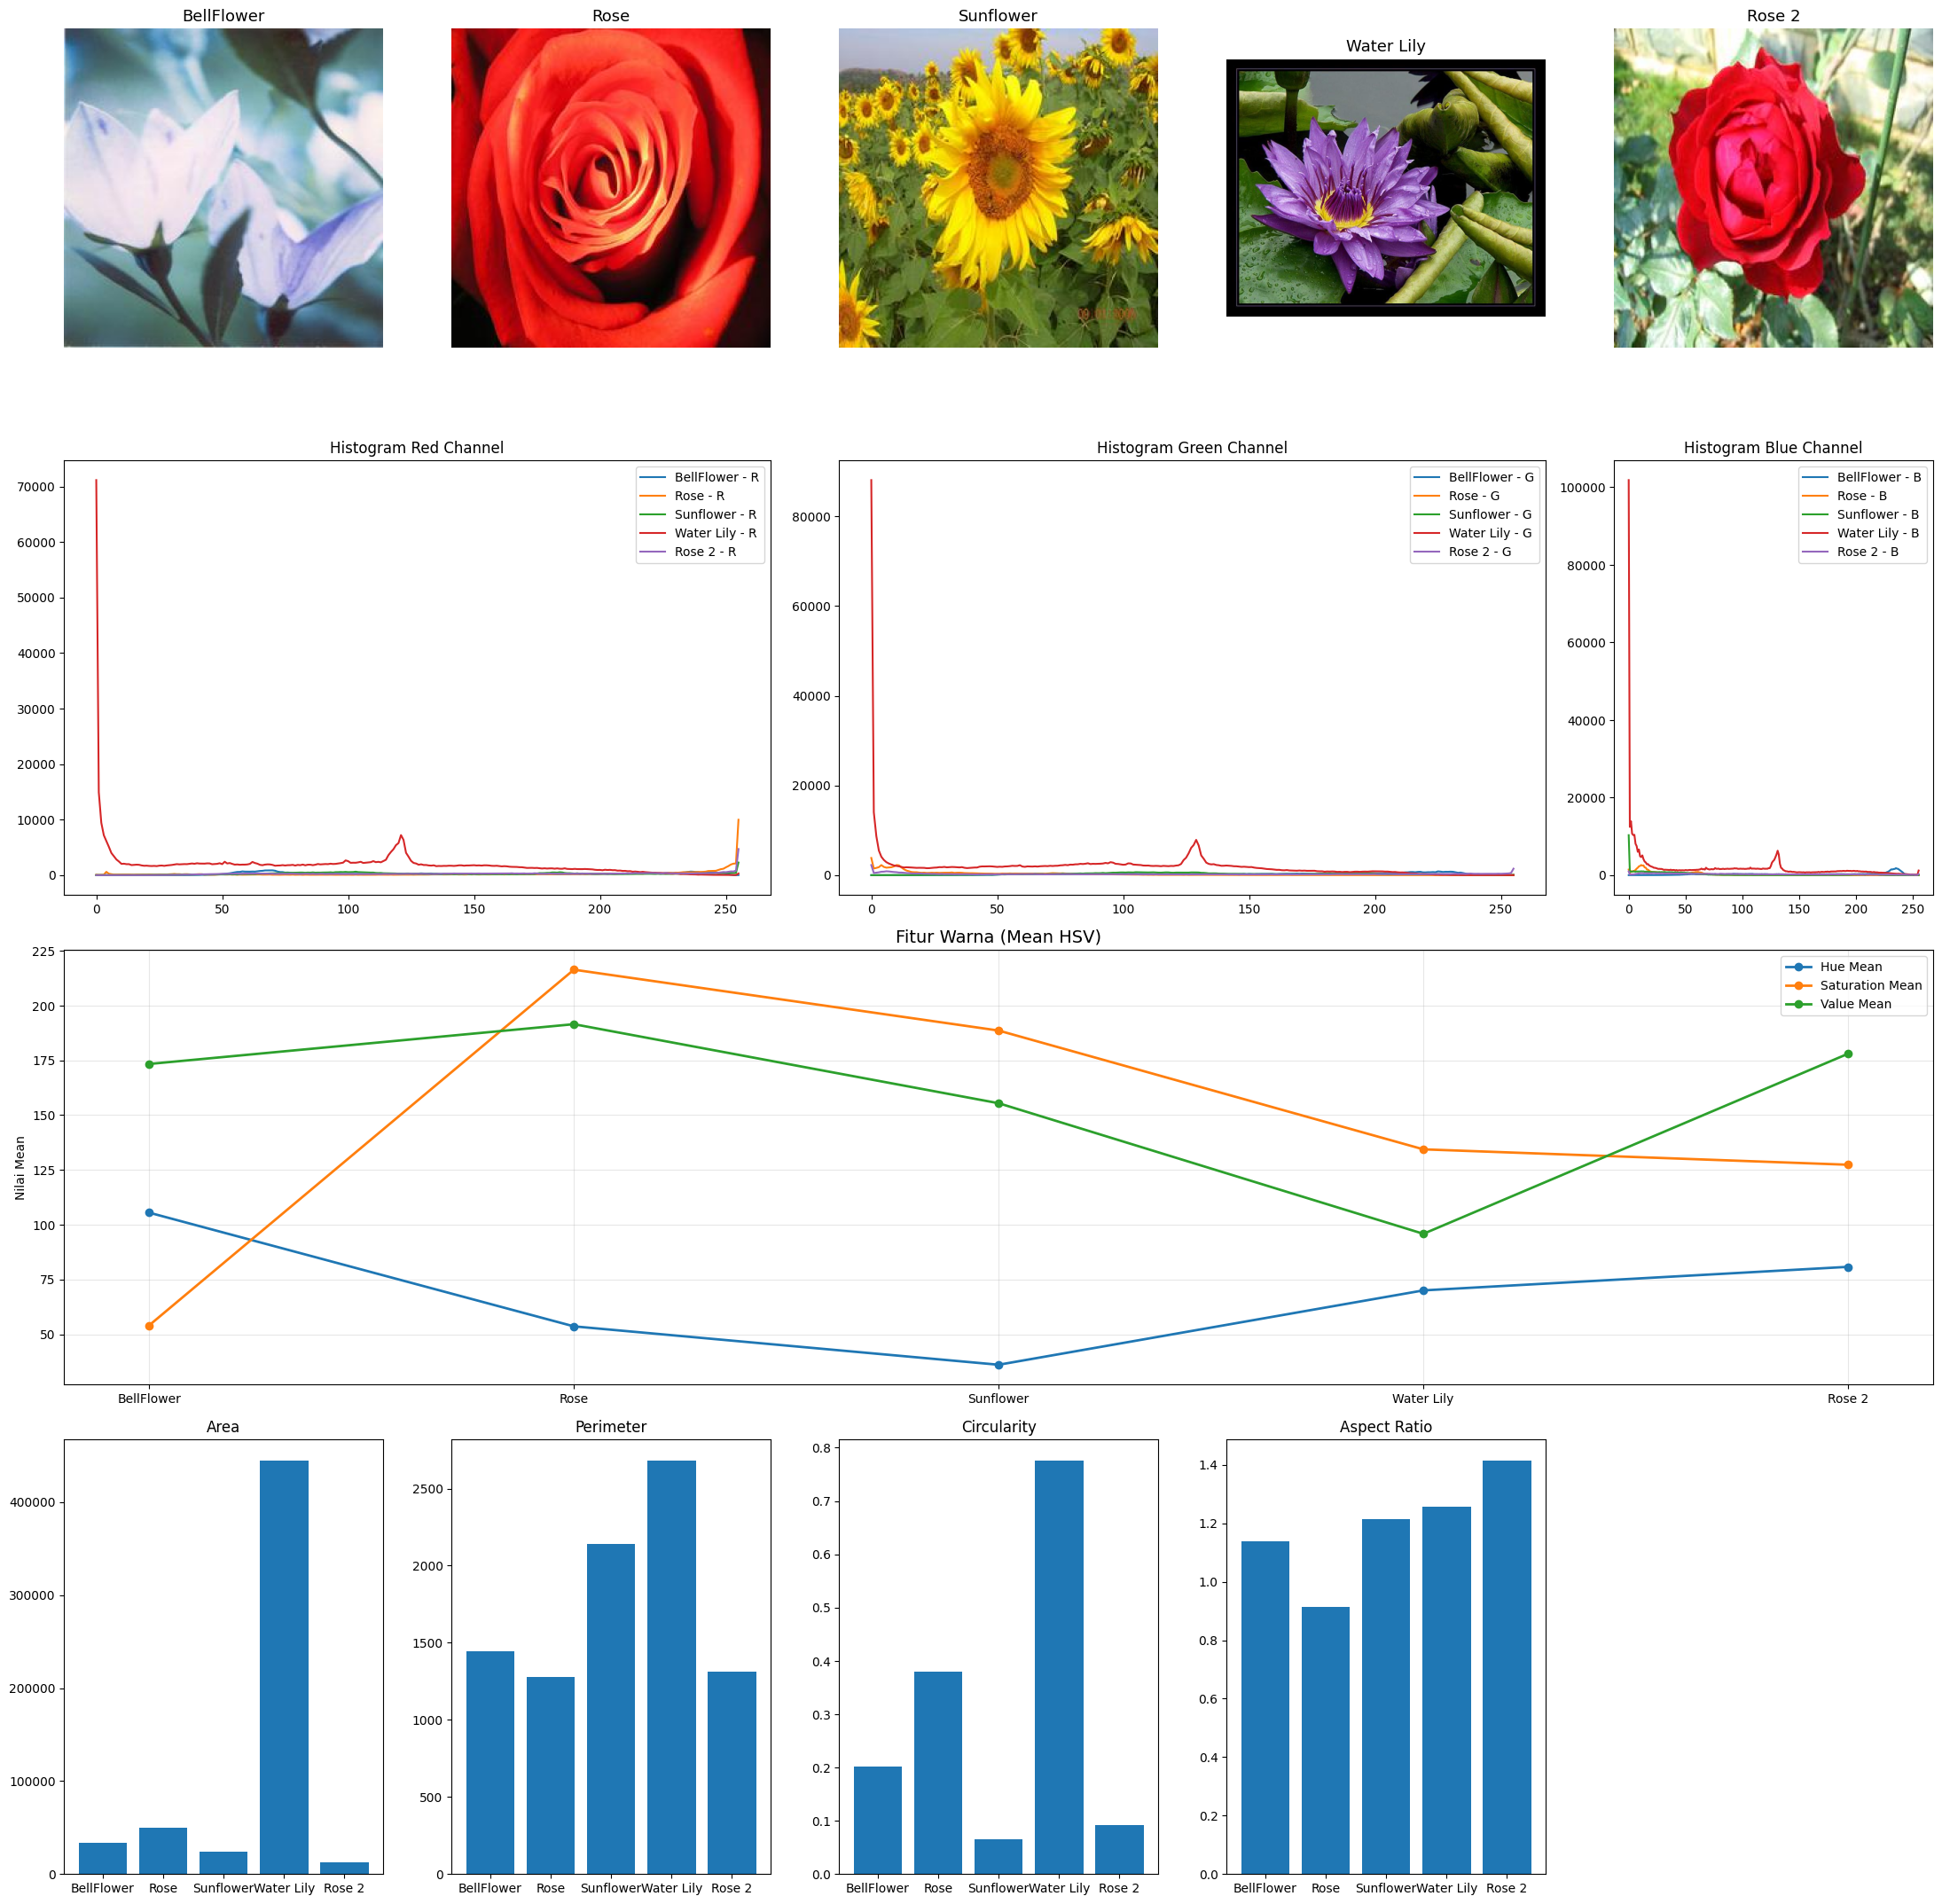

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# ----------------------- LOAD GAMBAR -----------------------
img_paths = [
    r"D:/Code/ML-Kuliah/Project-Bunga/flower_classification/train/bellflower/9525220_63e9effb95_c.jpg",
    r"D:/Code/ML-Kuliah/Project-Bunga/flower_classification/train/rose/1216789_7e50c0f967_c.jpg",
    r"D:/Code/ML-Kuliah/Project-Bunga/flower_classification/train/sunflower/5528601_b7a824d447_c.jpg",
    r"D:/Code/ML-Kuliah/Project-Bunga/flower_classification/train/water_lily/153099944_62dad1ed58_c.jpg",
    r"D:/Code/ML-Kuliah/Project-Bunga/flower_classification/train/rose/120295872_2d2f47e14e_c.jpg",
]

names = ["BellFlower", "Rose", "Sunflower", "Water Lily", "Rose 2"]

images = []
for p in img_paths:
    img = cv2.imread(p)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img)

# ----------------------- BIKIN CANVAS FIGURE -----------------------
fig = plt.figure(figsize=(22, 22))
gs = GridSpec(4, 5, figure=fig)  # 4 baris, 5 kolom

# ================================================================
# 🔵 BARIS 1 — TAMPILKAN 5 GAMBAR BUNGA
# ================================================================
for i, img in enumerate(images):
    ax = fig.add_subplot(gs[0, i])
    ax.imshow(img)
    ax.set_title(names[i], fontsize=13)
    ax.axis('off')

# ================================================================
# 🔵 BARIS 2 — HISTOGRAM RGB (3 plot)
# ================================================================
# Kumpulkan histogram
hist_r = []
hist_g = []
hist_b = []

for img in images:
    hist_r.append(cv2.calcHist([img], [0], None, [256], [0,256]))
    hist_g.append(cv2.calcHist([img], [1], None, [256], [0,256]))
    hist_b.append(cv2.calcHist([img], [2], None, [256], [0,256]))

# --- Plot Red ---
ax = fig.add_subplot(gs[1, 0:2])
for i,h in enumerate(hist_r):
    ax.plot(h, label=f"{names[i]} - R")
ax.set_title("Histogram Red Channel")
ax.legend()

# --- Plot Green ---
ax = fig.add_subplot(gs[1, 2:4])
for i,h in enumerate(hist_g):
    ax.plot(h, label=f"{names[i]} - G")
ax.set_title("Histogram Green Channel")
ax.legend()

# --- Plot Blue ---
ax = fig.add_subplot(gs[1, 4])
for i,h in enumerate(hist_b):
    ax.plot(h, label=f"{names[i]} - B")
ax.set_title("Histogram Blue Channel")
ax.legend()

# ================================================================
# 🔵 BARIS 3 — HISTOGRAM HSV (3 plot)
# ================================================================
hue_means = []
sat_means = []
val_means = []

for img in images:
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hue_means.append(np.mean(hsv[:,:,0]))
    sat_means.append(np.mean(hsv[:,:,1]))
    val_means.append(np.mean(hsv[:,:,2]))

# --- Plot Mean HSV sebagai line plot ---
ax = fig.add_subplot(gs[2, :])  # Span semua kolom di baris 3
ax.plot(names, hue_means, marker='o', label='Hue Mean', linewidth=2)
ax.plot(names, sat_means, marker='o', label='Saturation Mean', linewidth=2)
ax.plot(names, val_means, marker='o', label='Value Mean', linewidth=2)
ax.set_title("Fitur Warna (Mean HSV)", fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylabel("Nilai Mean")

# ================================================================
# 🔵 BARIS 4 — FITUR BENTUK (AREA, PERIMETER, CIRCULARITY, ASPECT RATIO)
# ================================================================
def extract_shape_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, th = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)

    cnts, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    c = max(cnts, key=cv2.contourArea)

    area = cv2.contourArea(c)
    peri = cv2.arcLength(c, True)

    circularity = 4 * np.pi * area / (peri ** 2)

    x,y,w,h = cv2.boundingRect(c)
    aspect_ratio = w / h
    
    return area, peri, circularity, aspect_ratio

areas = []
peris = []
circs = []
asps = []

for img in images:
    a,p,c,ar = extract_shape_features(img)
    areas.append(a)
    peris.append(p)
    circs.append(c)
    asps.append(ar)

# --- AREA ---
ax = fig.add_subplot(gs[3, 0])
ax.bar(names, areas)
ax.set_title("Area")

# --- PERIMETER ---
ax = fig.add_subplot(gs[3, 1])
ax.bar(names, peris)
ax.set_title("Perimeter")

# --- CIRCULARITY ---
ax = fig.add_subplot(gs[3, 2])
ax.bar(names, circs)
ax.set_title("Circularity")

# --- ASPECT RATIO ---
ax = fig.add_subplot(gs[3, 3])
ax.bar(names, asps)
ax.set_title("Aspect Ratio")

# Kosongkan 1 kolom terakhir (biar rapi)
fig.add_subplot(gs[3, 4]).axis('off')

plt.tight_layout()
plt.show()


In [8]:
train_folder = "flower_classification/train"

# ambil nama folder secara berurutan
class_names = sorted([
    d for d in os.listdir(train_folder)
    if os.path.isdir(os.path.join(train_folder, d))
])

# mapping kategori angka → nama folder
category_to_name = {i: class_names[i] for i in range(len(class_names))}

print("Mapping category → nama bunga:")
print(category_to_name)


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'flower_classification/train'

In [ ]:
df = pd.read_csv("flower_classification/train.csv")

print("Kolom dalam train.csv:", df.columns.tolist())

# -------------------------
# Detect kolom path gambar
# -------------------------
file_col = None
for c in df.columns:
    if df[c].astype(str).str.contains("train/").any():
        file_col = c
        break

# -------------------------
# Detect kolom kategori angka
# -------------------------
cat_col = None
for c in df.columns:
    if df[c].dtype in ["int64", "int32", "float64"] and c != file_col:
        cat_col = c
        break

print("Kolom PATH   =", file_col)
print("Kolom LABEL  =", cat_col)

# Extract fitur
X = []
y = []

for i, row in df.iterrows():
    img_path = os.path.join("flower_classification", row[file_col])
    label = int(row[cat_col])

    feat = extract_features(img_path)
    if feat is not None:
        X.append(feat)
        y.append(label)

X = np.array(X)
y = np.array(y)

print("Total data fitur:", len(y))


Kolom dalam train.csv: ['image:FILE', 'category']
Kolom PATH   = image:FILE
Kolom LABEL  = category
Total data fitur: 13642


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

svm = SVC(kernel='rbf', C=10, gamma='scale', probability=True)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

print("Akurasi:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Akurasi: 0.24127821753151568
              precision    recall  f1-score   support

           0       0.28      0.19      0.23       231
           1       0.27      0.67      0.38       260
           2       0.19      0.03      0.05       218
           3       0.20      0.16      0.17       255
           4       0.25      0.03      0.06       247
           5       0.00      0.00      0.00       181
           6       0.21      0.12      0.15       259
           7       0.28      0.09      0.13       253
           8       0.26      0.31      0.28       260
           9       0.24      0.45      0.31       259
          10       0.22      0.14      0.17       247
          11       0.24      0.27      0.25       244
          12       0.26      0.43      0.33       253
          13       0.19      0.39      0.26       244

    accuracy                           0.24      3411
   macro avg       0.22      0.23      0.20      3411
weighted avg       0.23      0.24      0.20      34

Saving waterlily.jpg to waterlily.jpg


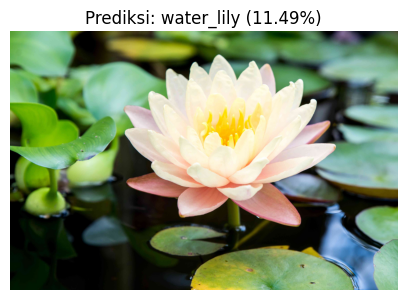

File waterlily.jpg: water_lily (11.49%)


In [ ]:
uploaded = files.upload()

for fname in uploaded.keys():
    tmp_path = "/tmp/" + fname
    with open(tmp_path, "wb") as f:
        f.write(uploaded[fname])

    feat = extract_features(tmp_path).reshape(1, -1)

    # prediksi kategori angka
    pred_cat = svm.predict(feat)[0]

    # konversi angka → nama bunga
    flower_name = category_to_name[pred_cat]

    # confidence score
    proba = svm.predict_proba(feat)[0]
    confidence = proba[pred_cat] * 100

    img = Image.open(tmp_path)
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prediksi: {flower_name} ({confidence:.2f}%)")
    plt.show()

    print(f"File {fname}: {flower_name} ({confidence:.2f}%)")
